In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
sentences = []
stereotypes = []

for line in open('./data/samples.txt'):
    words = line.split()
    sentences.append(' '.join(words[:-1]))
    stereotypes.append(int(words[-1]))

stereo_names = """
Emotional
Gentle
Empathetic
Neat
Social
Weak
Beautiful
Tough and rough
Self-confident
Professional
Rational
Providers
Leaders
Childish
Sexual
Strong
""".strip().split('\n')

In [6]:
from collections import Counter
import math
import random
import statistics

import matplotlib.pyplot as plt
from unidecode import unidecode
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

from masked_models.utils import calculate_logprob, tokenize, model_init

In [4]:

def bootstrap_ci(scores, alpha=0.95):
    """
    Bootstrapping based estimate.
    
    Return mean and confidence interval (lower and upper bound)
    """
    loc, scale = norm.fit(scores)    
    bootstrap = [sum(random.choices(scores, k=len(scores))) / len(scores) for _ in range(1000)]
    lower, upper = norm.interval(alpha, *norm.fit(bootstrap))
        
    return loc, lower, upper

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100it [00:32,  3.09it/s]


0.056256180092439816 -0.16139178087071673


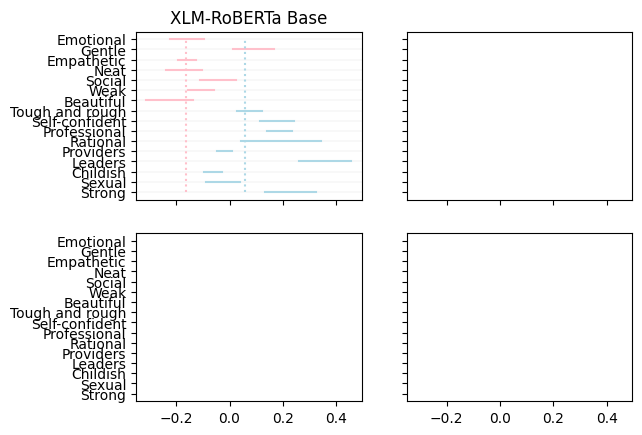

In [8]:
import matplotlib.pyplot as plt

def english_mlm_score(sample, templates, model, tokenizer, device):
    sen1, sen2 = templates[0](sentence), templates[1](sentence)
    a = calculate_logprob(sen1, sen2, tokenizer, model, device=device)
    b = calculate_logprob(sen2, sen1, tokenizer, model, device=device)
    return a - b


templates = [
    (lambda s: f'He said: "{s}"', lambda s: f'She said: "{s}"'),
    (lambda s: f'The man said: "{s}"', lambda s: f'The woman said: "{s}"'),
    (lambda s: f'"{s}", he said.', lambda s: f'"{s}", she said.'),
    (lambda s: f'"{s}", the man said.', lambda s: f'"{s}", the woman said.'),
]
    

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.reshape(-1)

for model_handle, model_name, ax in zip(
    ['xlm-roberta-base',],
    ['XLM-RoBERTa Base',],
    axes
):
    model, tokenizer = model_init(model_handle)

    scores = []
    for sentence, s in tqdm(zip(sentences[:100], stereotypes)):

        scores.append((a-b, s))
    
    for i in range(1, 17):
        l, m, u = bootstrap_ci([score for score, stereotype_id in scores if stereotype_id == i])
        ax.plot([l, u], [17-i, 17-i], c=('pink' if i < 8 else 'lightblue'))

    male_rate = np.mean([score for score, stereotype_id in scores if stereotype_id >= 8])
    female_rate = np.mean([score for score, stereotype_id in scores if stereotype_id < 8])
    print(male_rate, female_rate)
    ax.vlines(male_rate, 1, 16, linestyle=':', color='lightblue')
    ax.vlines(female_rate, 1, 16, linestyle=':', color='pink')
    
    ax.set_yticks(range(1, 17), stereo_names[::-1])
    ax.grid(visible=True, which='major', axis='y', c='lightgrey', linewidth=0.2)
    ax.set_title(model_name)

# set_size(5, 6)
# fig.subplots_adjust(left=0.2)
# plt.tight_layout()
# plt.savefig('lms.png', dpi=300)
# plt.show()
    
# Different prompts
# Different models
